In [29]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

In [30]:
# hyperparameters

batch_size = 64
learning_rate = 0.01
momentum = 0.5

In [36]:
# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                              #torchvision.transforms.RandomRotation(20)
                             ])),
  batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [37]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [38]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # N,784 -> N,128
        nn.ReLU(),
        nn.Linear(128, 64), 
        nn.ReLU(),
        nn.Linear(64, 12), 
        nn.ReLU(),
        nn.Linear(12, 3)
    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # N,3 -> N,12
        nn.ReLU(),
        nn.Linear(12, 64), 
        nn.ReLU(),
        nn.Linear(64, 128), 
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    for (img, _) in dataloader:
        img = img.to(device)
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = loss_fn(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    return (epoch, img, recon)


In [44]:
epochs = 12
outputs = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    output = train(train_dataloader, model, loss_fn, optimizer)
    outputs.append(output)
print("Finished")

Epoch 1
-------------------------------
Epoch:1, Loss:0.8126
Epoch 2
-------------------------------
Epoch:2, Loss:0.8250
Epoch 3
-------------------------------
Epoch:3, Loss:0.8038
Epoch 4
-------------------------------
Epoch:4, Loss:0.8795
Epoch 5
-------------------------------
Epoch:5, Loss:0.8239
Epoch 6
-------------------------------
Epoch:6, Loss:0.7834
Epoch 7
-------------------------------
Epoch:7, Loss:0.8089
Epoch 8
-------------------------------
Epoch:8, Loss:0.8510
Epoch 9
-------------------------------
Epoch:9, Loss:0.8586
Epoch 10
-------------------------------
Epoch:10, Loss:0.8768
Epoch 11
-------------------------------
Epoch:11, Loss:0.8708
Epoch 12
-------------------------------
Epoch:12, Loss:0.8305
Finished


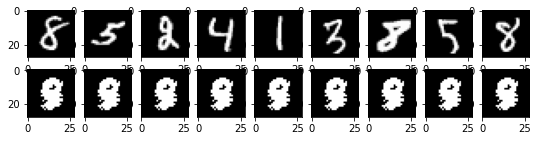

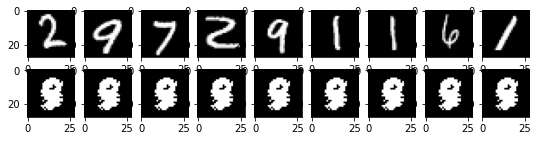

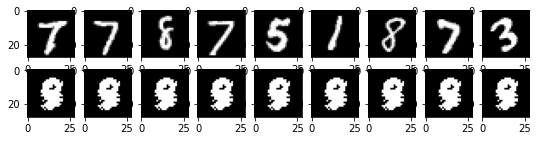

In [45]:
for k in range(0, epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])


    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

5